In [ ]:
!pip install -U -q PyDrive

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec  1 15:13:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-78e9d10c-59a7-4d5b-6b07-597c998d3703)


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 12.9 MB/s 
     |████████████████████████████████| 182 kB 85.2 MB/s 
     |████████████████████████████████| 7.6 MB 41.7 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import os
import chardet
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras import utils as np_utils
from keras.utils.np_utils import to_categorical

import transformers
from transformers import AutoTokenizer,TFDistilBertModel, DistilBertConfig
from transformers import TFAutoModel

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fileDownloaded = drive.CreateFile({'id':'1WPo4J9wi0bIXl2I5da_UYc1UqV8q_iRw'})
fileDownloaded.GetContentFile('data_init.csv')

In [ ]:
with open('data_init.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'Windows-1254',
 'confidence': 0.4445340489203496,
 'language': 'Turkish'}

In [ ]:
#df = pd.read_csv('data_init.csv',encoding='iso-8859-1',error_bad_lines=False, index_col = False)
df = pd.read_csv('data_init.csv',encoding='iso-8859-1',error_bad_lines=False, index_col = False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572928 entries, 0 to 572927
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ProductId                  572928 non-null  int64  
 1   Manufacturer Account Name  572928 non-null  object 
 2   Brand/Label                572928 non-null  object 
 3   IDEA''s Public ID          572928 non-null  int64  
 4   UPC Number                 525059 non-null  float64
 5   EAN Number                 115523 non-null  float64
 6   Catalog Number             572928 non-null  object 
 7   Invoice Description        572928 non-null  object 
 8   Catalog Description        387640 non-null  object 
 9   UNSPSC code                567206 non-null  float64
 10  IGCC code                  385015 non-null  float64
 11  CMD Category               567195 non-null  object 
 12  GTIN                       390194 non-null  float64
dtypes: float64(5), int64(2), obje

In [ ]:
cmd_count = df['CMD Category'].value_counts()
df['CMD_COUNT'] = df['CMD Category'].map(df['CMD Category'].value_counts())
cmd_count
threthold = 1000
others_count = cmd_count[cmd_count <=threthold ].count()
others_sum = cmd_count[cmd_count <= threthold].sum()
total = cmd_count.sum()
other_pct = others_sum/total*100
print("When threthold is", threthold, ", the total number of CMD categories moved to'other' categories is", others_count)
print("The total products in 'other' category is", others_sum)
print("Percentage of products that grouped in the 'other' category is", f'{other_pct:.2f}',"%")

When threthold is 1000 , the total number of CMD categories moved to'other' categories is 2429
The total products in 'other' category is 159837
Percentage of products that grouped in the 'other' category is 28.18 %


In [ ]:
df.head(10)

,ProductId,Manufacturer Account Name,Brand/Label,IDEA''s Public ID,UPC Number,EAN Number,Catalog Number,Invoice Description,Catalog Description,UNSPSC code,IGCC code,CMD Category,GTIN,CMD_COUNT
0,1,Rockwell Automation,Allen-Bradley,11994,8.210000e+11,NaN,20BC125A3ANNAEC0,PowerFlex 700 AC Drive 20B,"20B,125 A at 55 kW,400V AC Three Phase,IP20/NE...",39122001.0,5104.0,Inverter drive AC,8.210000e+11,6391.0
1,2,Eaton,Eaton,10964,7.870000e+11,NaN,SVX050A1-2A1N2,SVX Independent Drives,"SVX Independent Drives, 50HP, NEMA Type 1/IP21...",39122001.0,5104.0,Inverter drive AC,7.870000e+11,6391.0
2,3,Stanley Black & Decker,PROTO,12779,6.630000e+11,NaN,J55100a,Socket Set 13 Pieces 3/4 IN 12 Points,NaN,27111703.0,2034.0,Socket sets,6.630000e+11,189.0
3,4,ABB - Installation Products - Canada,Lumacell / Lightalarms,11316,6.250000e+11,NaN,RG12144QB2M50W,12V DECORATOR UNIT,NaN,39111709.0,NaN,Emergency light unit,NaN,3816.0
4,5,Legrand-Canada,Legrand - Wiremold (Canada),14054,7.870000e+11,NaN,DS4010A-DG,DS4000 ENTRANCE END FITTING DG,"Full-capacity end fitting. Includes four 3/4""""...",39131709.0,5570.0,Electrical wire or cable raceway,7.870000e+11,1757.0
5,6,Legrand-Wiremold,Legrand-Wiremold,11311,7.870000e+11,NaN,DSDWNS-DV,DS4000 DOWNWARD SERIES 2 DEV PLT,Accepts one Ortronics Series II module. Design...,39131709.0,5570.0,Electrical wire or cable raceway,7.870000e+11,1757.0
6,7,Siemens,Siemens,10991,8.880000e+11,NaN,1PH81331HF002BA1,"1PH813 MOTOR 20KW,2000RPM,INC,DE-NDE,KEY",NaN,26101114.0,NaN,Induction motor AC,NaN,1184.0
7,8,Lutron Electronics,Lutron,10977,2.755777e+10,NaN,RRD-W1RLD-PD,RADIORA2 1RLD WALL KEYPAD PALLADIUM,NaN,52161525.0,NaN,Remote control,NaN,330.0
8,9,ABB - Installation Products - Canada,T&B Cable Tray,11316,6.260000e+11,NaN,AH1424L06240,AL STR 4IN 24W LADDER TRAY 20FT,NaN,39131704.0,NaN,Cable tray,NaN,1852.0
9,10,Leviton,LEVITON,10962,7.847768e+10,NaN,420MI9WLEV,20A Mechanical Interlock - BLUE,NaN,39121404.0,4528.0,Electrical sleeves,7.847768e+10,1993.0


In [ ]:
df.loc[df["CMD_COUNT"] <= 1000, "CMD Category"] = "Other"

In [ ]:
cmd_count = df['CMD Category'].value_counts()
cmd_count

Other                                                  159837
Cable tray fitting and accessories                      21095
Circuit breakers                                        17929
Molded case circuit breakers                            17075
Electrical equipment maintenance and repair service     13541
                                                        ...  
Circular connectors                                      1041
Incandescent lamps                                       1034
Cartridge fuses                                          1029
Remote lighting fixture                                  1024
Midget fuses                                             1016
Name: CMD Category, Length: 130, dtype: int64

In [ ]:
df = df[df['CMD Category']!= 'Other']


In [ ]:
X = df['Invoice Description']
y = df['CMD Category']
X_train1,X_test,y_train1,y_test = train_test_split(X, y, test_size=0.1, random_state = 0)
X_train,X_val,y_train,y_val = train_test_split(X_train1, y_train1, test_size=0.1, random_state = 0)
encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test .shape)

(334602,)
(37179,)
(41310,)
(334602, 130)
(37179, 130)
(41310, 130)


In [ ]:
# Creating tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
bert = TFAutoModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=130)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

In [ ]:
for layer in bert.layers:
      layer.trainable = True

In [ ]:
# Tokenization of the data
def text_encode(text, tokenizer, max_len=100):
    tokens = text.apply(lambda x: tokenizer(x,return_tensors='tf', 
                                            truncation=True,
                                            padding='max_length',
                                            max_length=max_len, 
                                            add_special_tokens=True))
    input_ids= []
    attention_mask=[]
    for item in tokens:
        input_ids.append(item['input_ids'])
        attention_mask.append(item['attention_mask'])
    input_ids, attention_mask=np.squeeze(input_ids), np.squeeze(attention_mask)

    return [input_ids,attention_mask]

In [ ]:
X_train_input_ids, X_train_attention_mask = text_encode(X_train, tokenizer, max_len=100)
X_val_input_ids, X_val_attention_mask = text_encode(X_val, tokenizer, max_len=100)
X_test_input_ids, X_test_attention_mask = text_encode(X_test, tokenizer, max_len=100)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
num_filters = [100,50,25]
kernel_sizes = [3,4,5]

def build_model_multi_scale_cnn(bert_model, maxlen=100):
   input_ids = tf.keras.Input(shape=(maxlen,),dtype=tf.int32, name='input_ids')
   attention_mask = tf.keras.Input(shape=(maxlen,),dtype=tf.int32, name='attention_mask')

   sequence_output = bert_model(input_ids,attention_mask=attention_mask)
   #bert_output = sequence_output[0][:,0,:]
   bert_output = sequence_output[0]

   conv_layers_for_all_kernel_sizes = []
   for kernel_size, filters in zip(kernel_sizes, num_filters):
      conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(bert_output)
      conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
      conv_layer = keras.layers.Dropout(rate=0.5)(conv_layer)
      conv_layers_for_all_kernel_sizes.append(conv_layer)
    
   conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
   #last_hidden_output = keras.layers.Dropout(rate=0.3)(conv_output)

   output = tf.keras.layers.Dense(128,activation='relu')(conv_output)
   output = tf.keras.layers.Dropout(0.3)(output)
   output = tf.keras.layers.Dense(130,activation='softmax')(output)

   model = tf.keras.models.Model(inputs = [input_ids,attention_mask], outputs = [output])
   model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

   return model

In [ ]:
model_multi_scale_cnn = build_model_multi_scale_cnn(bert, maxlen=100)

In [ ]:
history = model_multi_scale_cnn.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    batch_size=32,
    validation_data=([X_val_input_ids, X_val_attention_mask], y_val),
    epochs=5
)

Epoch 1/5
10457/10457 [==============================] - 3521s 335ms/step - loss: 2.1843 - accuracy: 0.5251 - val_loss: 0.9576 - val_accuracy: 0.7677
Epoch 2/5
10457/10457 [==============================] - 3514s 336ms/step - loss: 1.0893 - accuracy: 0.7399 - val_loss: 0.6531 - val_accuracy: 0.8267
Epoch 3/5
10457/10457 [==============================] - 3509s 336ms/step - loss: 0.7992 - accuracy: 0.7987 - val_loss: 0.5241 - val_accuracy: 0.8525
Epoch 4/5
10457/10457 [==============================] - 3512s 336ms/step - loss: 0.6396 - accuracy: 0.8311 - val_loss: 0.4623 - val_accuracy: 0.8662
Epoch 5/5
10457/10457 [==============================] - 3512s 336ms/step - loss: 0.5351 - accuracy: 0.8524 - val_loss: 0.4284 - val_accuracy: 0.8740


In [ ]:
history2 = model_multi_scale_cnn.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    batch_size=32,
    validation_data=([X_test_input_ids, X_test_attention_mask], y_test),
    epochs=5
)

Epoch 1/5
10457/10457 [==============================] - 3576s 341ms/step - loss: 2.1730 - accuracy: 0.5289 - val_loss: 0.9754 - val_accuracy: 0.7622
Epoch 2/5
10457/10457 [==============================] - 3580s 342ms/step - loss: 1.0854 - accuracy: 0.7429 - val_loss: 0.6636 - val_accuracy: 0.8230
Epoch 3/5
10457/10457 [==============================] - 3578s 342ms/step - loss: 0.7911 - accuracy: 0.8009 - val_loss: 0.5278 - val_accuracy: 0.8529
Epoch 4/5
10457/10457 [==============================] - 3579s 342ms/step - loss: 0.6349 - accuracy: 0.8319 - val_loss: 0.4652 - val_accuracy: 0.8654
Epoch 5/5
10457/10457 [==============================] - 3581s 342ms/step - loss: 0.5298 - accuracy: 0.8537 - val_loss: 0.4292 - val_accuracy: 0.8749


In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

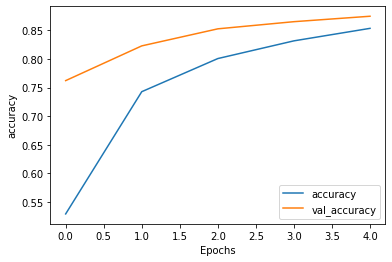

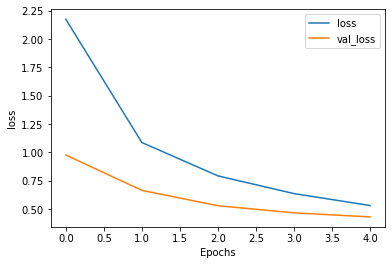

In [ ]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")